In [1]:
from os.path import join
from time import perf_counter

import metrics as M
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from scipy.stats import cumfreq

Metric Functions Using: cuda


In [2]:
POS = ["prostate_supine", "prostate_upright"]
OBJ = [
    "bladder",
    "femoral_head_l",
    "femoral_head_r",
    "prostate",
    "rectum",
]
CLR = [
    "green",
    "orange",
    "red",
    "blue",
    "purple",
]
BLADDER = 0
L_FEMUR = 1
R_FEMUR = 2
PROSTATE = 3
RECTUM = 4

In [3]:
def show3D(matrix, title="", size=(8, 8), downsample=1):
    matrix = matrix[::downsample, ::downsample, ::downsample]

    labels = np.unique(matrix)
    labels = labels[labels != 0]

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(projection="3d")

    for i, label in enumerate(labels):
        mask = (matrix == label).astype(np.uint8)

        if np.sum(mask) == 0:
            continue

        verts, faces, _, _ = measure.marching_cubes(mask, level=0)

        ax.plot_trisurf(
            verts[:, 0],
            verts[:, 1],
            faces,
            verts[:, 2],
            color=CLR[i],
            linewidth=0,
            antialiased=True,
            alpha=0.9,
        )

    zdim, ydim, xdim = matrix.shape
    ax.set_xlim(0, zdim)
    ax.set_ylim(0, ydim)
    ax.set_zlim(0, xdim)
    ax.set_box_aspect(matrix.shape)

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [4]:
def pad(data, gaps):
    return [str(d).ljust(g + 1) for d, g in zip(data, gaps)]


def makeTable(rowNames, rows, labels, rounding=3, minWidth=0):
    for r in range(len(rows)):
        rows[r] = [round(i, rounding) if isinstance(i, float) else i for i in rows[r]]

    gaps = [max(map(len, rowNames))]
    for i in range(len(labels)):
        colMax = len(labels[i])
        for row in rows:
            colMax = max(len(str(row[i])), colMax, minWidth)
        gaps.append(colMax)

    rows = [list(map(str, row)) for row in rows]

    rowSep = "+" + "+".join("-" * (i + 2) for i in gaps) + "+"
    print(rowSep)
    print("| " + "| ".join(pad([""] + labels, gaps)) + "|")
    print(rowSep)
    for name, row in zip(rowNames, rows):
        print("| " + "| ".join(pad([name] + row, gaps)) + "|")
        print(rowSep)

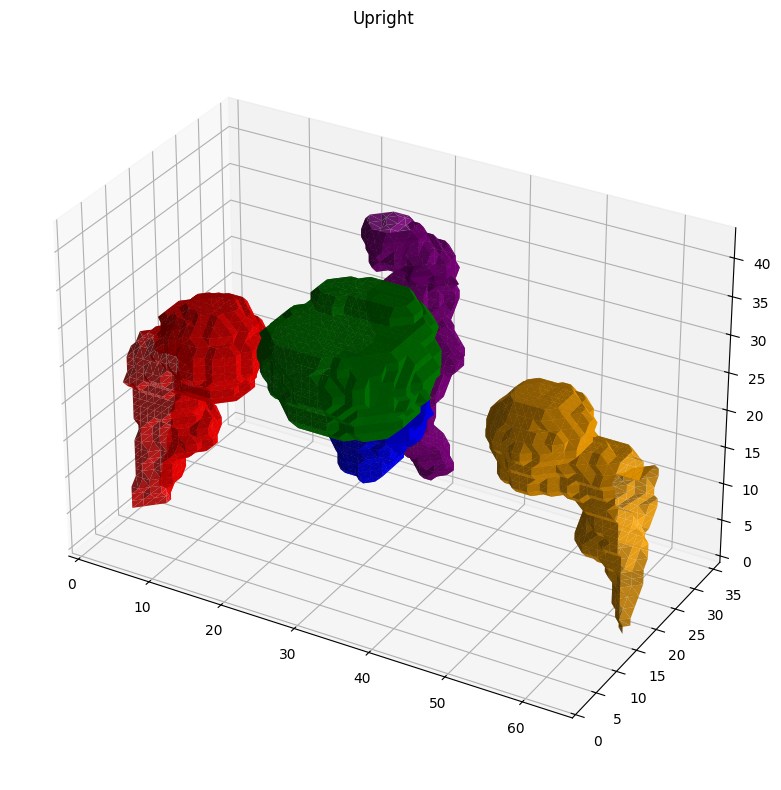

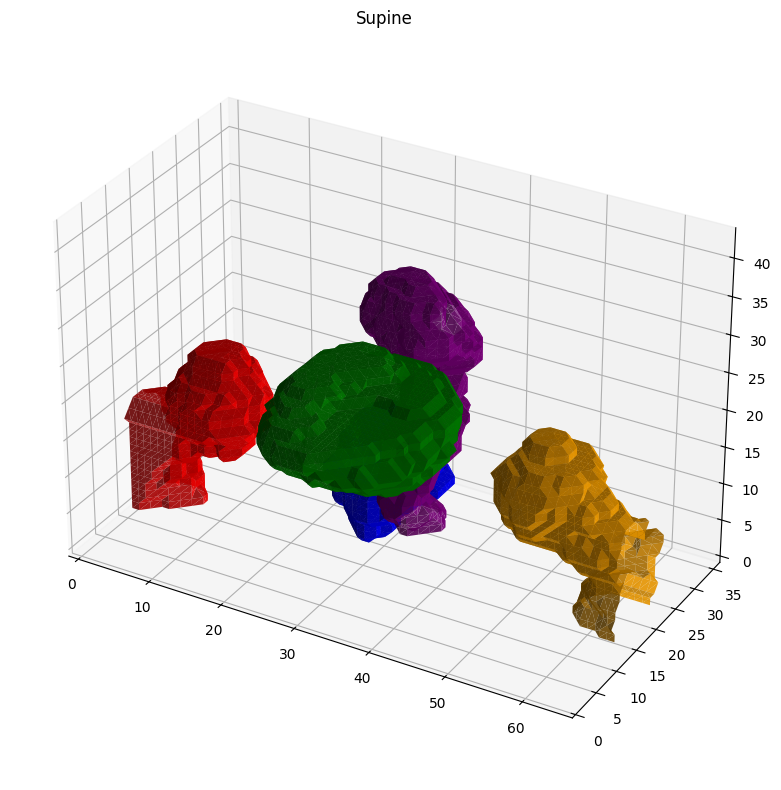

In [5]:
def load(pos, downsample=1):
    files = []
    for obj in OBJ:
        files.append(f"{pos}_{obj}.npy")
    return [
        np.load(join("data", file)).transpose(2, 1, 0)[::downsample, ::downsample, ::downsample]
        for file in files
    ]


masksU = load(POS[0])
masksS = load(POS[1])

combU = np.zeros_like(masksU[PROSTATE], dtype=int)
combS = np.zeros_like(masksS[PROSTATE], dtype=int)

for i, m in enumerate(masksU):
    combU[np.where(m)] = i + 1

for i, m in enumerate(masksS):
    combS[np.where(m)] = i + 1

show3D(combU, "Upright", downsample=4)
show3D(combS, "Supine", downsample=4)

# Volumetric / Surface Area Analysis

In [ ]:
IDX = [BLADDER, PROSTATE, RECTUM]

labels = [OBJ[idx].capitalize() for idx in IDX]
rNames = ["Upright Vol", "Supine Vol", "Vol Diff", "Upright SA", "Supine SA", "SA Diff"]

volU = np.array([M.getVolume(masksU[idx]) for idx in IDX])
volS = np.array([M.getVolume(masksS[idx]) for idx in IDX])
volDiff = volU - volS

saU = np.array([M.getSurfaceArea(masksU[idx]) for idx in IDX])
saS = np.array([M.getSurfaceArea(masksS[idx]) for idx in IDX])
saDiff = saU - saS

makeTable(rNames, [volU, volS, volDiff, saU, saS, saDiff], labels)

+-------------+---------+----------+--------+
|             | Bladder | Prostate | Rectum |
+-------------+---------+----------+--------+
| Upright Vol | 154820  | 42760    | 95445  |
+-------------+---------+----------+--------+
| Supine Vol  | 166215  | 50735    | 101140 |
+-------------+---------+----------+--------+
| Vol Diff    | -11395  | -7975    | -5695  |
+-------------+---------+----------+--------+
| Upright SA  | 16636   | 6815     | 16667  |
+-------------+---------+----------+--------+
| Supine SA   | 20695   | 8465     | 17005  |
+-------------+---------+----------+--------+
| SA Diff     | -4059   | -1650    | -338   |
+-------------+---------+----------+--------+


# Rigid Registration / Alignment Analysis

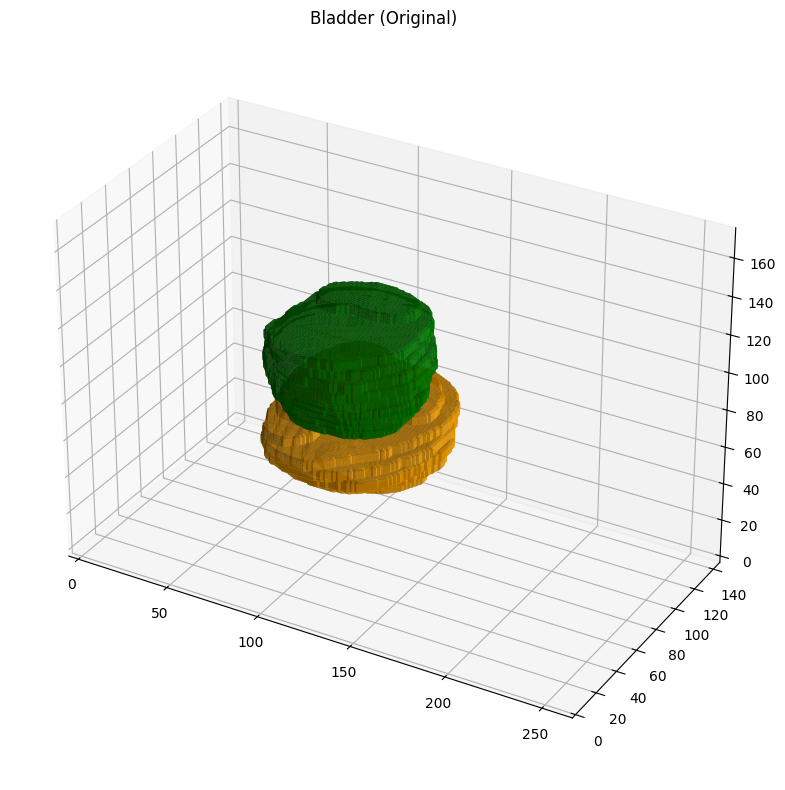

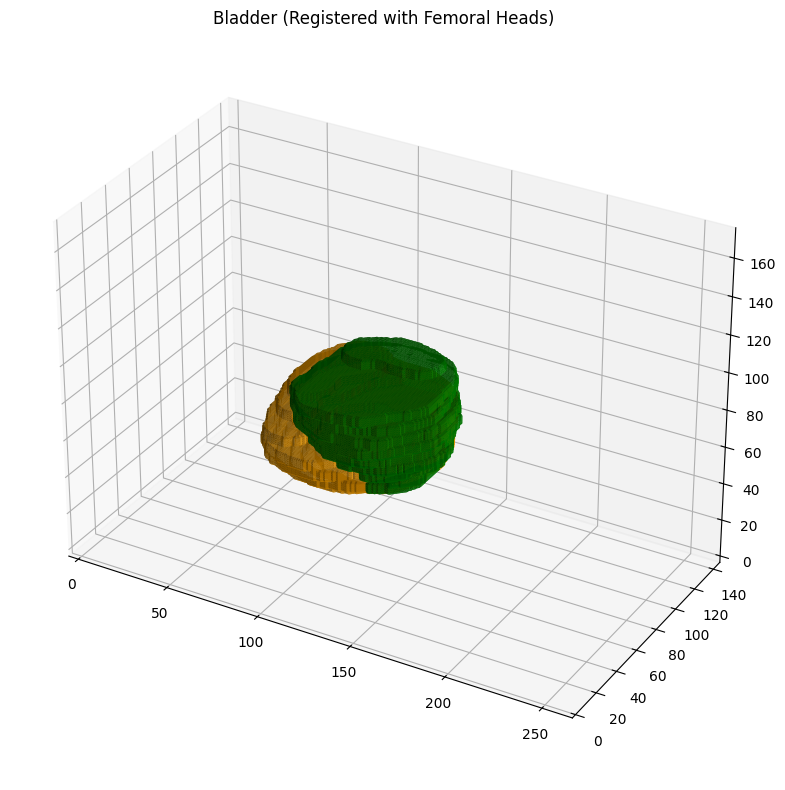

+------------------------------+--------------------------+---------------------------+-------------------------+
|                              | U2S Bladder Displacement | U2S Prostate Displacement | U2S Rectum Displacement |
+------------------------------+--------------------------+---------------------------+-------------------------+
| Left(-ve)/Right(+ve)         | -15.039                  | -13.116                   | -12.356                 |
+------------------------------+--------------------------+---------------------------+-------------------------+
| Anterior(-ve)/Posterior(+ve) | 12.635                   | 11.174                    | 11.76                   |
+------------------------------+--------------------------+---------------------------+-------------------------+
| Inferior(-ve)/Superior(+ve)  | -14.203                  | -9.491                    | 7.628                   |
+------------------------------+--------------------------+---------------------------+-

In [7]:
u2s_transVec = M.getTranslationVector(masksU[L_FEMUR] | masksU[R_FEMUR], masksS[L_FEMUR] | masksS[R_FEMUR])

bladder_u2s_dVec = (M.getTranslationVector(masksU[BLADDER], masksS[BLADDER]) - u2s_transVec).tolist()
prostate_u2s_dVec = (M.getTranslationVector(masksU[PROSTATE], masksS[PROSTATE]) - u2s_transVec).tolist()
rectum_u2s_dVec = (M.getTranslationVector(masksU[RECTUM], masksS[RECTUM]) - u2s_transVec).tolist()

display = np.zeros_like(masksS[PROSTATE], dtype=int)
display[np.where(masksU[BLADDER])] = 1
display[np.where(masksS[BLADDER])] = 2
show3D(display, "Bladder (Original)")

bladder_regU = M.applyTranslationVector(masksU[BLADDER], u2s_transVec)
display = np.zeros_like(masksS[PROSTATE], dtype=int)
display[np.where(bladder_regU)] = 1
display[np.where(masksS[BLADDER])] = 2
show3D(display, "Bladder (Registered with Femoral Heads)")

bladder_u2s_dVec.append(np.linalg.norm(bladder_u2s_dVec))
prostate_u2s_dVec.append(np.linalg.norm(prostate_u2s_dVec))
rectum_u2s_dVec.append(np.linalg.norm(rectum_u2s_dVec))

data = np.array([bladder_u2s_dVec, prostate_u2s_dVec, rectum_u2s_dVec]).T

makeTable(["Left(-ve)/Right(+ve)", "Anterior(-ve)/Posterior(+ve)", "Inferior(-ve)/Superior(+ve)", "Magnitude"], data, ["U2S Bladder Displacement", "U2S Prostate Displacement", "U2S Rectum Displacement"])

# Margin Dilation Analysis

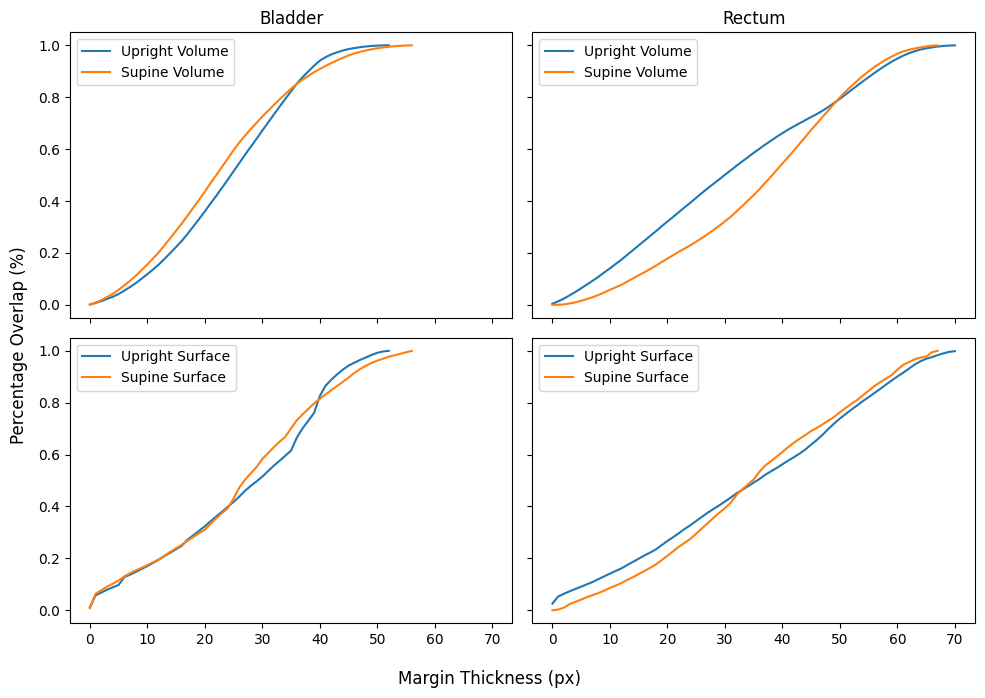

In [8]:
def marginDilationAnalysis(dmap, mask):
    sd = dmap[np.where(mask)]
    hsd = dmap[np.where(M.getSurface(mask))]

    vol, sa = [], []
    tVol = M.getVolume(mask)
    tSa = M.getSurfaceArea(mask)
    for i in range(np.ceil(np.max(sd)).astype(int)):
        vol.append(np.sum(sd <= i) / tVol)
        sa.append(np.sum(hsd <= i) / tSa)
    return vol, sa


prostate_dmapU = M.getDMap(masksU[PROSTATE])
prostate_dmapS = M.getDMap(masksS[PROSTATE])

bladder_volU, bladder_saU = marginDilationAnalysis(prostate_dmapU, masksU[BLADDER])
bladder_volS, bladder_saS = marginDilationAnalysis(prostate_dmapS, masksS[BLADDER])

rectum_volU, rectum_saU = marginDilationAnalysis(prostate_dmapU, masksU[RECTUM])
rectum_volS, rectum_saS = marginDilationAnalysis(prostate_dmapS, masksS[RECTUM])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 7))
fig.supylabel("Percentage Overlap (%)")
fig.supxlabel("Margin Thickness (px)")

ax0.plot(bladder_volU, label="Upright Volume")
ax0.plot(bladder_volS, label="Supine Volume")
ax0.legend()

ax1.plot(rectum_volU, label="Upright Volume")
ax1.plot(rectum_volS, label="Supine Volume")
ax1.legend()

ax2.plot(bladder_saU, label="Upright Surface")
ax2.plot(bladder_saS, label="Supine Surface")
ax2.legend()

ax3.plot(rectum_saU, label="Upright Surface")
ax3.plot(rectum_saS, label="Supine Surface")
ax3.legend()

ax0.set_title("Bladder")
ax1.set_title("Rectum")

plt.tight_layout()

# Surface Distance Analysis

In [9]:
def plotCumFreq(arr, title):
    res = cumfreq(arr, numbins=150)
    x = res.lowerlimit + np.linspace(0, res.binsize * res.cumcount.size, res.cumcount.size)

    plt.figure()
    plt.title(title)
    plt.bar(x, res.cumcount)
    plt.show()

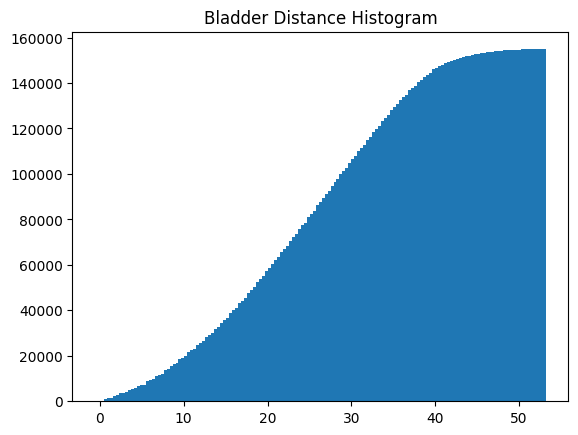

In [10]:
sd = prostate_dmapU[np.where(masksU[BLADDER])]
plotCumFreq(sd, "Bladder Distance Histogram")

In [11]:
bladder_sdU = prostate_dmapU[np.where(masksU[BLADDER])]
bladder_sdS = prostate_dmapS[np.where(masksS[BLADDER])]

rectum_sdU = prostate_dmapU[np.where(masksU[RECTUM])]
rectum_sdS = prostate_dmapS[np.where(masksS[RECTUM])]

bladder_sdU_analysis, lbl = M.seriesAnalysis(bladder_sdU, labels=True)
bladder_sdS_analysis = M.seriesAnalysis(bladder_sdS)

rectum_sdU_analysis = M.seriesAnalysis(rectum_sdU)
rectum_sdS_analysis = M.seriesAnalysis(rectum_sdS)

makeTable(
    ["Upright Bladder Surface Distance", "Supine Bladder Surface Distance"],
    [bladder_sdU_analysis, bladder_sdS_analysis],
    lbl,
    minWidth=8,
)
makeTable(
    ["Upright Rectum Surface Distance", "Supine Rectum Surface Distance"],
    [rectum_sdU_analysis, rectum_sdS_analysis],
    lbl,
    minWidth=8,
)

+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
|                                  | MIN      | P05      | P10      | AVG      | MDN      | P90      | P95      | MAX      |
+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
| Upright Bladder Surface Distance | 0.0      | 6.0      | 9.0      | 24.168   | 24.556   | 38.013   | 40.608   | 52.612   |
+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
| Supine Bladder Surface Distance  | 0.0      | 4.899    | 7.348    | 22.813   | 22.0     | 39.294   | 43.795   | 56.763   |
+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
+---------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
|

In [12]:
bladder_fsU, _ = M.getFacingSurfaces(masksU[BLADDER], masksU[PROSTATE], cutAwayDist=16)
bladder_fsS, _ = M.getFacingSurfaces(masksS[BLADDER], masksS[PROSTATE], cutAwayDist=16)
rectum_fsU, _ = M.getFacingSurfaces(masksU[RECTUM], masksU[PROSTATE], cutAwayDist=16)
rectum_fsS, _ = M.getFacingSurfaces(masksS[RECTUM], masksS[PROSTATE], cutAwayDist=16)

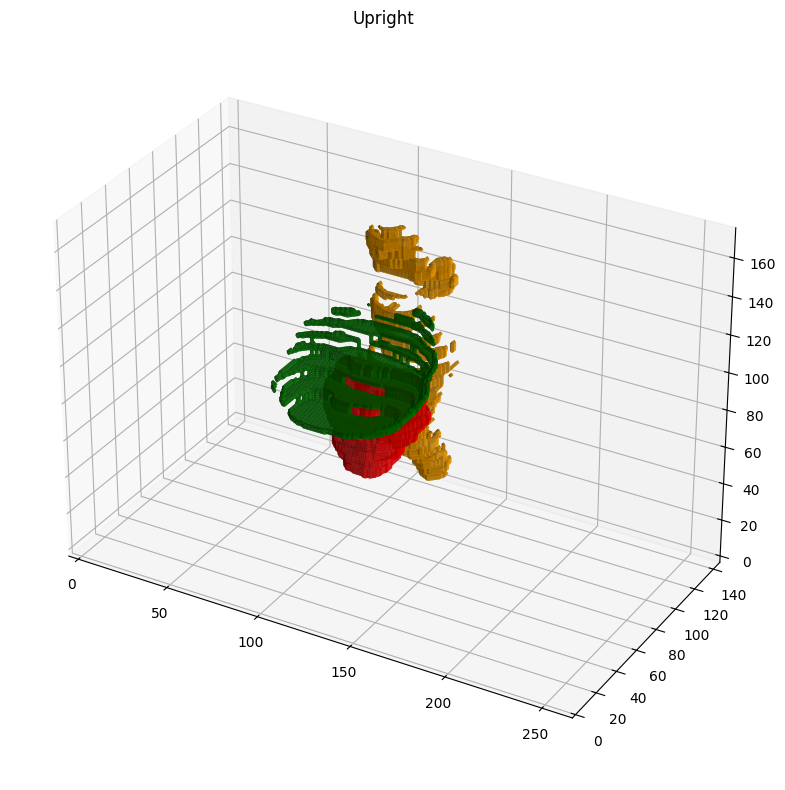

In [13]:
displayU = np.zeros_like(masksU[PROSTATE], dtype=int)

displayU[np.where(bladder_fsU)] = 1
displayU[np.where(rectum_fsU)] = 2
displayU[np.where(masksU[PROSTATE])] = 3

show3D(displayU, "Upright")

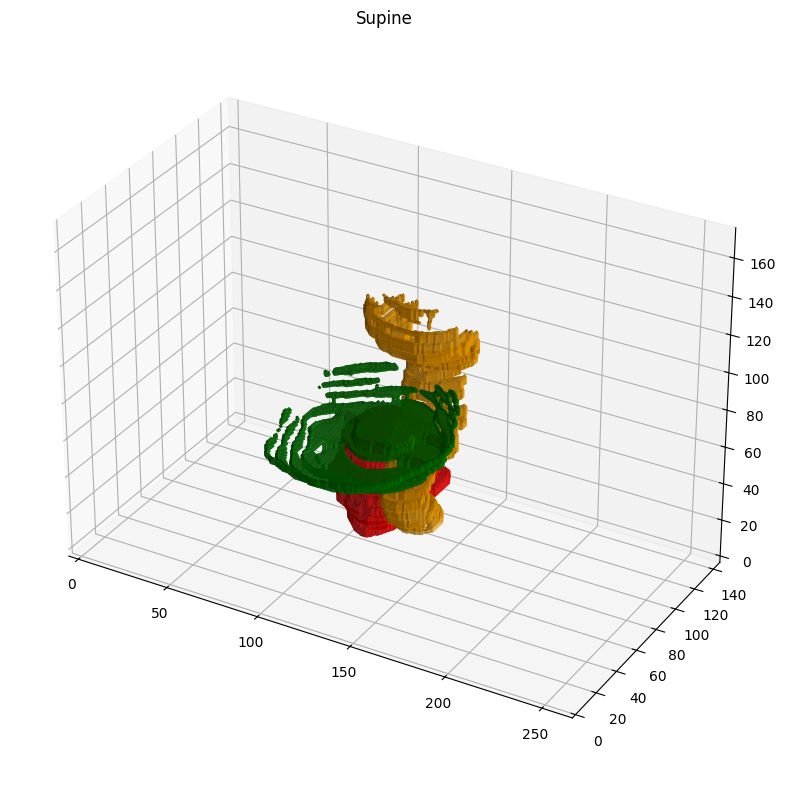

In [14]:
displayS = np.zeros_like(masksS[PROSTATE], dtype=int)

displayS[np.where(bladder_fsS)] = 1
displayS[np.where(rectum_fsS)] = 2
displayS[np.where(masksS[PROSTATE])] = 3

show3D(displayS, "Supine")

In [15]:
bladder_fspU = M.getFacingSurfacePercentage(masksU[BLADDER], bladder_fsU)
bladder_fspS = M.getFacingSurfacePercentage(masksS[BLADDER], bladder_fsS)

print(f"Upright Bladder Facing Surface Percentage: {(bladder_fspU * 100):.3f}%")
print(f"Supine Bladder Facing Surface Percentage: {(bladder_fspS * 100):.3f}%\n")

rectum_fspU = M.getFacingSurfacePercentage(masksU[RECTUM], rectum_fsU)
rectum_fspS = M.getFacingSurfacePercentage(masksS[RECTUM], rectum_fsS)

print(f"Upright Supine Facing Surface Percentage: {(rectum_fspU * 100):.3f}%")
print(f"Supine Supine Facing Surface Percentage: {(rectum_fspS * 100):.3f}%\n")

Upright Bladder Facing Surface Percentage: 30.314%
Supine Bladder Facing Surface Percentage: 33.636%

Upright Supine Facing Surface Percentage: 41.549%
Supine Supine Facing Surface Percentage: 53.126%



In [16]:
bladder_fsdU = M.getFacingSurfaceDistance(prostate_dmapU, bladder_fsU)
bladder_fsdS = M.getFacingSurfaceDistance(prostate_dmapS, bladder_fsS)

rectum_fsdU = M.getFacingSurfaceDistance(prostate_dmapU, rectum_fsU)
rectum_fsdS = M.getFacingSurfaceDistance(prostate_dmapS, rectum_fsU)

bladder_fsdU_analysis, lbl = M.seriesAnalysis(bladder_fsdU, labels=True)
bladder_fsdS_analysis = M.seriesAnalysis(bladder_fsdS)

rectum_fsdU_analysis = M.seriesAnalysis(rectum_fsdU)
rectum_fsdS_analysis = M.seriesAnalysis(rectum_fsdS)

makeTable(
    ["Upright Bladder Facing Surface Distance", "Supine Bladder Facing Surface Distance"],
    [bladder_fsdU_analysis, bladder_fsdS_analysis],
    lbl,
    minWidth=8,
)
makeTable(
    ["Upright Rectum Facing Surface Distance", "Supine Rectum Facing Surface Distance"],
    [rectum_fsdU_analysis, rectum_fsdS_analysis],
    lbl,
    minWidth=8,
)

+-----------------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
|                                         | MIN      | P05      | P10      | AVG      | MDN      | P90      | P95      | MAX      |
+-----------------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
| Upright Bladder Facing Surface Distance | 0.0      | 1.0      | 1.0      | 9.843    | 8.775    | 19.87    | 22.226   | 30.935   |
+-----------------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
| Supine Bladder Facing Surface Distance  | 0.0      | 1.0      | 1.0      | 14.392   | 10.63    | 35.749   | 42.261   | 52.65    |
+-----------------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
+----------------------------------------+----------+----------+----------+-

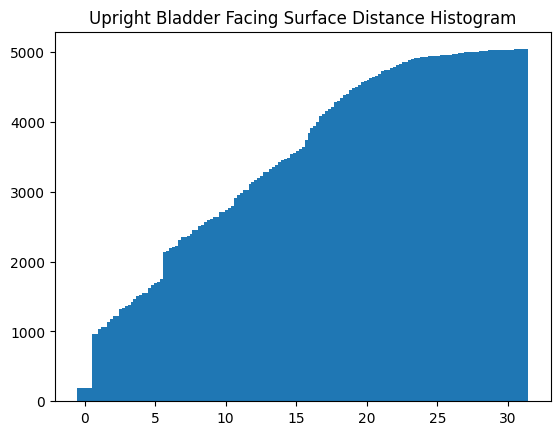

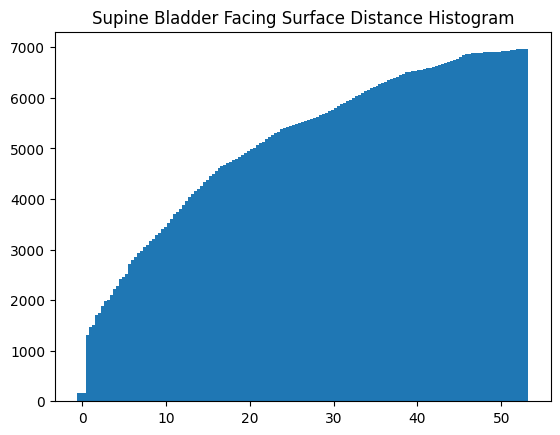

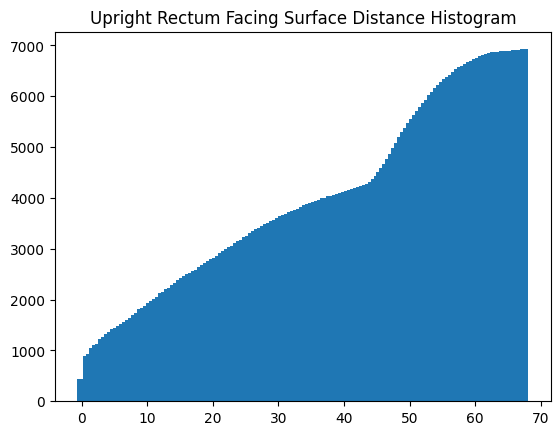

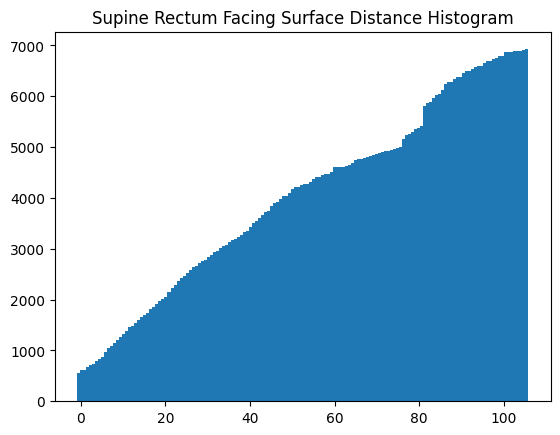

In [17]:
plotCumFreq(bladder_fsdU, "Upright Bladder Facing Surface Distance Histogram")
plotCumFreq(bladder_fsdS, "Supine Bladder Facing Surface Distance Histogram")
plotCumFreq(rectum_fsdU, "Upright Rectum Facing Surface Distance Histogram")
plotCumFreq(rectum_fsdS, "Supine Rectum Facing Surface Distance Histogram")